<img src=images/vqd.png>

In [19]:
import qiskit_nature
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import Psi4Driver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper
qiskit_nature.settings.use_pauli_sum_op = False

mol = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["H", "H"],
    coords=([0.0, 0.0, -0.3625], [0.0, 0.0, 0.3625]),
    multiplicity=1,
    charge=0,
)

prob_unmod = Psi4Driver.from_molecule(mol).run()

problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(prob_unmod)

num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

mapper = ParityMapper(num_particles=num_particles)  # Set Mapper

hamiltonian = mapper.map(problem.second_q_ops()[0])  # Set Hamiltonian

print(hamiltonian)

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-1.05016043+0.j,  0.40421466+0.j, -0.40421466+0.j, -0.01134688+0.j,
  0.18037525+0.j])


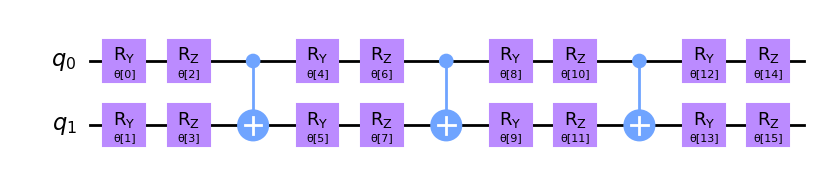

In [20]:
from qiskit.circuit.library import EfficientSU2
#ansatz = TwoLocal(rotation_blocks=['ry', 'rz'], entanglement_blocks='cz')
ansatz = EfficientSU2(hamiltonian.num_qubits)

from qiskit.algorithms.optimizers import SLSQP
optimizer = SLSQP(maxiter=150, max_evals_grouped=1)

ansatz.decompose().draw('mpl')

In [21]:
from qiskit.primitives import Sampler, Estimator
from qiskit.algorithms.state_fidelities import ComputeUncompute

estimator = Estimator()
sampler = Sampler()
fidelity = ComputeUncompute(sampler)

ComputeUnCompute uses the sampler primitive to calculate the state fidelity of two quantum circuits following the compute-uncompute method

fedility (state overlap): <img src=images/cuc_sol.png />

The initial release of Qiskit Runtime includes two primitives:

Sampler: Generates quasi-probability distribution from input circuits.

Estimator: Calculates expectation values from input circuits and observables.

In [22]:
k = 2
betas = [10,10]

In [23]:
counts = []
values = []
paramsl = []
steps = []
metal = []
conc = []

def callback(eval_count, params, value, meta, step):
    counts.append(eval_count)
    paramsl.append(params)
    values.append(value)
    steps.append(step)
    metal.append(meta)

<img src=images/vqd_cost.png>

In [24]:
from qiskit.algorithms.eigensolvers import VQD


vqd = VQD(estimator, fidelity, ansatz, optimizer, k=k, betas=betas, callback=callback)
result = vqd.compute_eigenvalues(operator = hamiltonian)
vqd_values = result.eigenvalues

In [25]:
print(vqd_values.real)

[-1.86712041 -1.24188292]


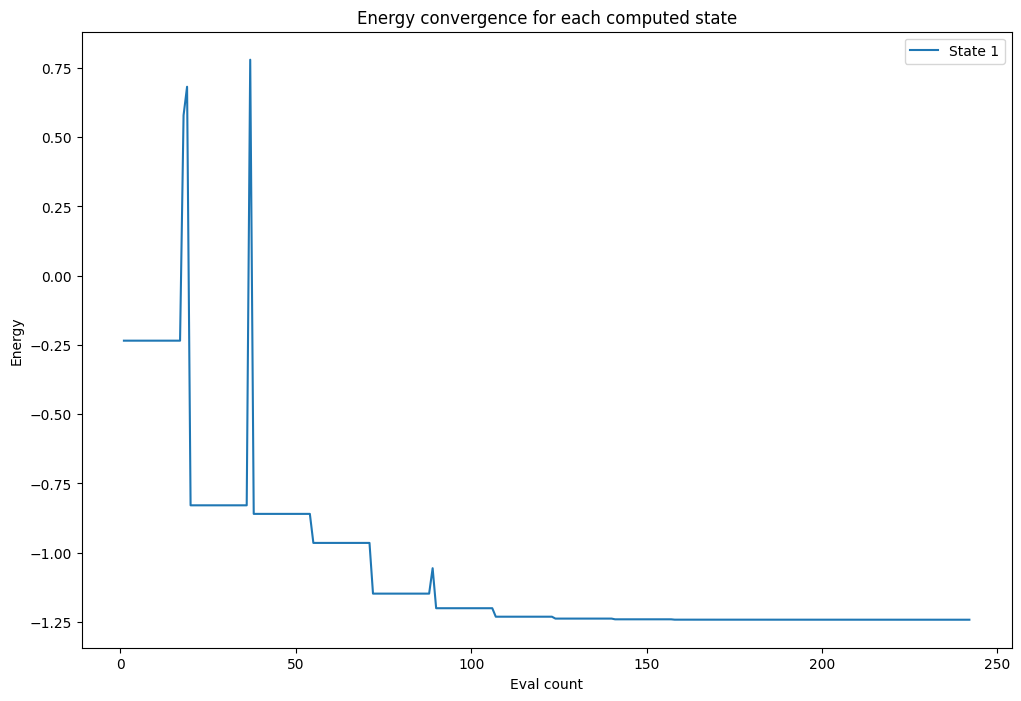

In [26]:
import numpy as np
import matplotlib.pyplot as plt
g1=plt

g1.rcParams["figure.figsize"] = (12, 8)

steps = np.asarray(steps)
counts = np.asarray(counts)
values = np.asarray(values)


_counts = counts[np.where(steps == 2)]
_values = values[np.where(steps == 2)]
g1.plot(_counts, _values, label=f"State {2-1}")

g1.xlabel("Eval count")
g1.ylabel("Energy")
g1.title("Energy convergence for each computed state")
g1.legend(loc="upper right")
g1.show()

In [27]:
from qiskit.algorithms.eigensolvers import NumPyEigensolver


exact_solver = NumPyEigensolver(k=2)
exact_result = exact_solver.compute_eigenvalues(hamiltonian)
ref_values = exact_result.eigenvalues

In [34]:
from qiskit.quantum_info import Statevector, concurrence
steps = np.asarray(steps)
paramsl = np.asarray(paramsl)
params2 = paramsl[np.where(steps == 2)]
for j in params2:
    bound_ansatz = ansatz.bind_parameters(j)
    i = Statevector.from_instruction(bound_ansatz)
    conc.append(concurrence(i))

[Text(0.5, 0, 'Evaluation Count'), Text(0, 0.5, 'Energy')]

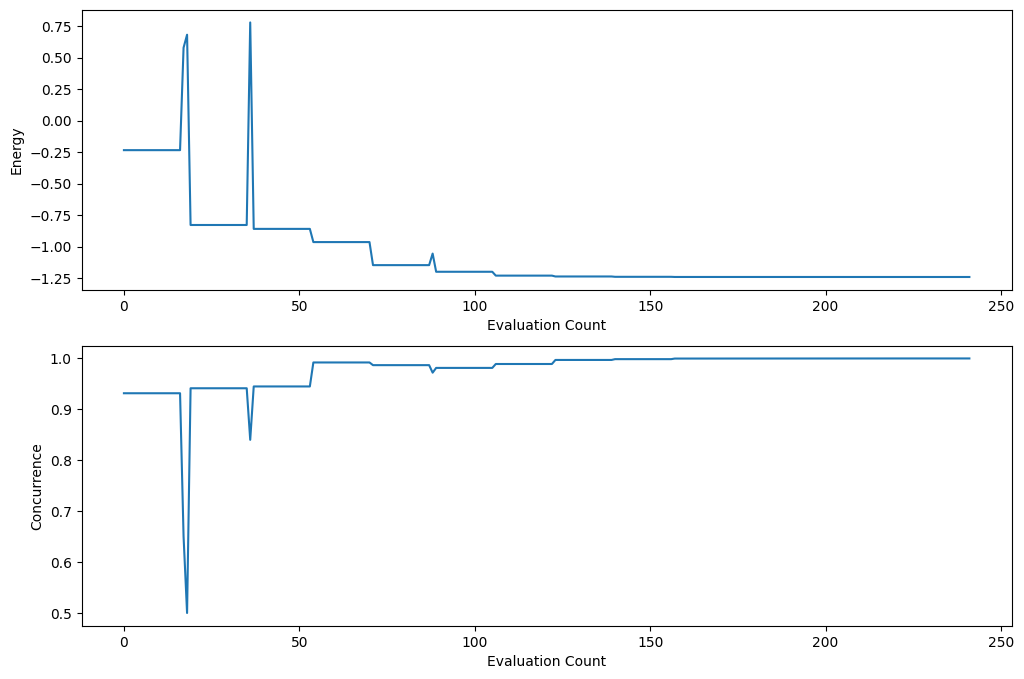

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (b,z) = plt.subplots(2, figsize=(12, 8))

_values = values[np.where(steps == 2)]

z.plot(range(0,len(conc)), conc)
z.set(xlabel='Evaluation Count', ylabel='Concurrence')

metal = np.asarray(metal)
metalp = metal[np.where(steps == 2)]
b.plot(range(0, len(conc)), _values)
#b.plot(range(0,len(conc)), [i['variance'] for i in metalp])#error output if ideal simulator like this
b.set(xlabel='Evaluation Count', ylabel='Energy')

In [41]:
metal


array([{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {},
       {}, {}, {}, {}, {}